In [9]:
import pyvisa
import numpy as np
import time
import pandas as pd
import os
import CVCommands
from os import path
from datetime import datetime
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from pyvisa import ResourceManager, constants
from usb.core import find as finddev
from IPython.display import clear_output

In [25]:
sampName = 'VT667_12'
cellNum = '001'
comment = 'Room Temp CV for CdTe'

#Scan range
V_i = -2 #Initial bias V (V)
V_f = 1 #Final bias V (V)
V_step = 50 #Number of steps
#Voltage set function
fastScan = True #Uses a voltage fit to speed up scan time, if fit is not available one will be made
V_fitmax = 5 #Maximum Vsmu output
V_fitmin = -3 #Minimum Vsmu output
fitby = 'SMU' #'SMU' or 'CONTROL', fit by setting the value of the [SMU] or by [CONTROL]ling to setpoint value fitting by SMU is much faster
#Scan settings
freq = 1e6 #Measurement frequency in Hz
amp = 0.05 #Measurement AC amplitude in V
num_avg = 5 #Number of waveforms to average for each measurement
delay = 0.1 #Delay between changing to new value
#Pre-bias settings
holdbias = False #Toggle to hold device at bias before measurement
hold_val = V_i #Voltage to hold at in V
hold_time = 60 #Time to hold voltage in s
#Pulsed measurement settings
pulseScan = False #Measurement V pulse on or off
pulse_time = 5 #Pulse time in s
#Soak at voltage before taking measurement
soak = False #Soak on/off
soak_time = 2*60 #Soak time in s
####################################################

#PID tuning parameters for V setpoint
Ku = 1.3
Tu = 1
CVCommands.P = 0.45*Ku
CVCommands.I = 0.54*Ku/Tu
CVCommands.D = 0.0

CVCommands.offset = 0.01 #Acceptable tolerance for voltage setpoint in V

CVCommands.reset_i = 0 #Subtract this value from voltage setpoint to improve PID speed
CVCommands.reset = 5 #Subtract value from setpoint after reset trigger

CVCommands.reset_val = 500 #Trigger voltage setpoint reset after iterations
CVCommands.shutoff_val = 500 #Max iterations before shutdown
CVCommands.num_avg = num_avg
CVCommands.mvavg_num = 20 #Number of points to calculate voltage setpoint moving average

CVCommands.v_ceiling = 35 #Max allowable voltage sent to SMU, maximum value 35

CVCommands.trig_delay = 1 #Delay before triggering measurement
CVCommands.meas_speed = 'SLOW2' #FAST, MED, SLOW, SLOW2
CVCommands.lowz = 'ON' #LCR low Z mode

CVCommands.LCR_timeout = 600*1000 #Timeout in ms for LCR query



Fast scan = True
Pulse scan = False
Pre-bias = False
Soak = False




Voltage sweep:   0%|          | 0/50 [00:00<?, ?it/s]

Saving as: VT699_43_CV_0221221605_100kHz                          
Measurement complete
Data saved


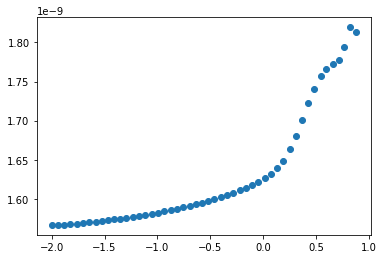

In [26]:
os.chdir('/home/pi/Desktop/CV')
foldname = datetime.today().strftime('%m-%d-%Y')
now = datetime.now()
currtime = now.strftime("%m%d%y%H%M")
currtime_format = now.strftime("%m/%d/%y %H:%M")
month_format=datetime.today().strftime('%m-%Y')

if os.path.isdir(month_format) is False:
    os.mkdir(month_format)
    os.chdir(month_format)
else:
    os.chdir(month_format) 

SMU, DMM, LCR, AFG = CVCommands.inst_connect(
    SMUon = True, DMMon = True, LCRon = True, AFGon = False)

if os.path.isdir(foldname) is False:
    os.mkdir(foldname)

os.chdir(foldname)

CVCommands.fastScan = fastScan
CVCommands.sampName = sampName
CVCommands.LCR_configure()
CVCommands.LCR_CGD()

error = False
time.sleep(1)
################################################
print('Fast scan = '+str(fastScan))
print('Pulse scan = '+str(pulseScan))
print('Pre-bias = '+str(holdbias))
print('Soak = '+str(holdbias))
print('\n')

if fastScan == True:
    if path.exists(''.join(['/home/pi/Desktop/VoltageFits/','Vfitdata_',sampName])):
        CVCommands.fit_df = pd.read_csv(''.join(['/home/pi/Desktop/VoltageFits/','Vfitdata_',sampName]),sep='\t')
    else:
        CVCommands.voltFit(V_fitmin,V_fitmax,fitby)
        CVCommands.fit_df = pd.read_csv(''.join(['/home/pi/Desktop/VoltageFits/','Vfitdata_',sampName]),sep='\t') 



CVCommands.setFreq(freq)
CVCommands.set_oscVolt(amp)
try:  
    V_arr = []
    c_arr = []
    g_arr = []
    d_arr = []
    f_arr = []
    if holdbias is True:

        CVCommands.setBias(hold_val,True,fastScan)

        print('Prebiasing at '+str(hold_val)+'                               ')
        time.sleep(hold_time)
    for i in tqdm(np.linspace(V_i,V_f,V_step),desc=''.join(['Voltage sweep'])):
        
        CVCommands.setBias(i,True,fastScan)
        if soak == True:
            time.sleep(soak_time)
        c, g, d = CVCommands.getData()
        V_arr.append(float(DMM.query(':READ?')))
        c_arr.append(c)
        g_arr.append(g)
        d_arr.append(d)
        f_arr.append(freq)
        if pulseScan == True:
            CVCommands.setBias(0,True,fastScan)
            DMM.query(':READ?')
            time.sleep(pulse_time)
    
except KeyboardInterrupt as e:
    error = True
    print(e)
    print('Interrupt')
CVCommands.offBias()
LCR.write(':TRIG INT')

tempdict = {
    'DC Bias (V)' : V_arr,
    'Capacitance (F)' : c_arr,
    'Conductance (S)' : g_arr,
    'Dissipation (D)' : d_arr,
    'Frequency (Hz)' : f_arr,
}

if pulseScan == False:
    pulse_time = 0
if soak == False:
    soak_time = 0
if holdbias == False:
    hold_time = 0
info_labels = ['Sample Name: ','Cell Number: ','Comment: ','V start: ','V final: ','V steps: ','Freq: ','AC amp: ','Time: '
               ,'Pulse time: ','Pre-bias: ','LCR averaging: ','Soak time: ']
info_data = [sampName,cellNum,comment,V_i,V_f,V_step,freq,amp,currtime_format,pulse_time,hold_time,num_avg,soak_time]

dictlen = len(tempdict[list(tempdict.keys())[0]])

infolen = len(info_data)

if dictlen >= infolen:
    info_labels = info_labels+[np.nan]*(dictlen-infolen)
    info_data = info_data+[np.nan]*(dictlen-infolen)
else:
    for i in tempdict:
        tempdict[i] = tempdict[i]+[np.nan]*(infolen-dictlen)

tempdict['Info1'] = info_labels
tempdict['Info2'] = info_data
    
print('Saving as: '+''.join([sampName,'_CV','_',currtime,'_',"{:.0f}".format(freq/1000),'kHz']))
globals()[''.join([sampName,'_CV','_',currtime,'_',"{:.0f}".format(freq/1000),'kHz'])] = pd.DataFrame(tempdict)
globals()[''.join([sampName,'_CV','_',currtime,'_',"{:.0f}".format(freq/1000),'kHz'])].to_csv(''.join([sampName,'_CV','_',currtime,'_',"{:.0f}".format(freq/1000),'kHz']),sep='\t')

print('Measurement complete')
print('Data saved')
    
plt.scatter(globals()[''.join([sampName,'_CV','_',currtime,'_',"{:.0f}".format(freq/1000),'kHz'])]['DC Bias (V)']
         ,globals()[''.join([sampName,'_CV','_',currtime,'_',"{:.0f}".format(freq/1000),'kHz'])]['Capacitance (F)'])

if error == False:
    time.sleep(0.5)
    #CVCommands.playchest()
else:
    CVCommands.playrand(10,0.05)